# InstaDeep Technical Task

For this task, I have devised a physics-based method towards destabilising some protein complex A-B while maintaining another complex A-C, where B and C have overlapping interaction sites. The pipeline consists of a number of steps that first aim to gain a better understanding of the interactions between proteins A and B/C, following by exploitation of this insight for suggestion of viable mutations.

I have written a number of functions for the task (found in the `Utils`, `Seq_Utils`, and `Mutate` modules), with this notebook being used to string them together into a pipeline. 

> In this notebook, each function will be briefly described when it is used, but they are all documented within the respective modules as well for further information

In [1]:
import Utils
import Seq_Utils
import Mutate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/boraguloglu/anaconda3/envs/instadeep/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/boraguloglu/anaconda3/envs/instadeep/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyRosetta-4 2023 [Rosetta PyRosetta4.conda.mac.cxx11thread.serialization.python311.Release 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.mac.cxx11thread.serialization.python311.Release r366 2024.01+release.00b79147e63 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/boraguloglu/anaconda3/envs/instadeep/lib/python3.11/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-1198952146 seed_offset=0 real_seed=-1198952146 thread_index=0
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-1198952146 RG_type=mt19937


We start by fetching the relevant structures from the PDB using the `Utils.download_pdb` function. Since crystal structures often have missing residues and crystallographic factors and/or water molecules within them, we will need to sanitise the structure before any downstream work is done. To do this, we use `pdbfixer` which is distributed as a part of the OpenMM toolkit for biomolecular simulations. This provides a fast way to prepare a structure for further work using force fields, as we will be doing.

> To sanitise, I provide here the `Utils.fix_pdb_structure` function. This function removes crystallographgic factors and uses the SEQRES records in the PDB file to identify missing residues and/or atoms. I have also provided the option to forego the building of terminal missing residues, as these are often long chains that are not relevant to the task. Usually, these are removed during biomolecular modelling tasks, and so we do this by default here as well.

In [2]:
prot_B_code, prot_C_code = "7Z0X", "6M0J"

Utils.download_pdb(prot_B_code, f"../data/{prot_B_code}.pdb")
Utils.download_pdb(prot_C_code, f"../data/{prot_C_code}.pdb")

Utils.fix_pdb_structure(f"../data/{prot_B_code}.pdb", "../data/complex_AB_fixed.pdb")
Utils.fix_pdb_structure(f"../data/{prot_C_code}.pdb", "../data/complex_AC_fixed.pdb")

# Setting the chain of protein A and the binding partner in both structures
prot_A_chain_in_complex_AB = "C"
prot_B_chains_in_complex_AB = ["A", "B"]

prot_A_chain_in_complex_AC = "B"
prot_C_chains_in_complex_AC = ["A"]

# We'll also set the interfaces here in "docking convention"
complex_AB_interface = "AB_C"
complex_AC_interface = "A_B"

Next, we will make sure that we standardise the numbering of our chain of interest. For this, I provide the `Utils.make_equivalent_chains` function. This function extracts the sequence of some chain of interest from two structures, aligns these, and then ensures that the numbering of residues for this chain is equivalent across both structures. That is, each residue will have the same residue ID in either structure. The function also returns a "merged" sequence of the protein of interest based on the alignment. We will use this merged sequence later to identify evolutionarily probable mutations.

Having done this, we will also save the chain of interest from each structure by using the `Utils.save_chain_of_interest` function.

In [3]:
total_n_residues, merged_seq = Utils.make_equivalent_chains("../data/complex_AB_fixed.pdb", 
                                                            "../data/complex_AC_fixed.pdb", 
                                                            prot_A_chain_in_complex_AB, 
                                                            prot_A_chain_in_complex_AC)

Utils.save_chain_of_interest("../data/complex_AB_fixed.pdb", 
                             [prot_A_chain_in_complex_AB], 
                             "../data/complex_AB_fixed_prot_A.pdb")
Utils.save_chain_of_interest("../data/complex_AC_fixed.pdb", 
                             [prot_A_chain_in_complex_AC], 
                             "../data/complex_AC_fixed_prot_A.pdb")

Next, we aim to identify residues within protein A that are in th einterfaces with either protein B or protein C. Commonly, there are two ways of doing this:

1. Distance. Mark a residue as being in the interface it its minimum heavy atom distance to residues of the binding partner is below some threshold.
2. Buried surface area (BSA). If a residue buries some of its solvent-accessible surface area (SASA) during complex formation, it is considered to be interacting with the binding partner.

> In this case functions to achieve both are provided in the form of the `Utils.get_interface_residues` and `Utils.get_by_res_BSA` functions. Either are valid and common ways to identify residues of interest, but come with certain advantages and limitations. The distance-based method is a simple metric to identify interactions and can be further modified to identify different types of interactions, but is sensitive to the chosen distance threshold. The BSA metric, on the other hand is directly relevant to complex stabiity and thermodynamics, but does not take into account different types of interactions. It may also miss important electrostatic interactions that are mediated via water bridges.
>> _NB:_ The `Utils.get_by_res_BSA` function relies on the `SASA` module which is available on the GitHub repo for Biopython, but is not yet included in the `conda` distribution. I have provided this here with no modifications.

Here, we use the BSA method. I have modified this method to provide BSA values decomposed into side chain and main chain/backbone atoms, as a mutation is unlikely to affect the contribution of a residue if it is only interacting with protein B/C vis its main chain. As such, we'd ideally like to specifically consider residues whose side chains make contributions to the interaction.

Lastly, we put all of the information we have generated so far into a `DataFrame`.

In [4]:

within_dist_protB = Utils.get_interface_residues("../data/complex_AB_fixed.pdb", 
                                                 prot_A_chain_in_complex_AB, 
                                                 prot_B_chains_in_complex_AB, 
                                                 distance=4.5)
within_dist_protC = Utils.get_interface_residues("../data/complex_AC_fixed.pdb", 
                                                 prot_A_chain_in_complex_AC, 
                                                 prot_C_chains_in_complex_AC, 
                                                 distance=4.5)

protB_bb_bsas, protB_sc_bsas = Utils.get_by_res_BSA("../data/complex_AB_fixed_prot_A.pdb", 
                                                    "../data/complex_AB_fixed.pdb", 
                                                    prot_A_chain_in_complex_AB)
protC_bb_bsas, protC_sc_bsas = Utils.get_by_res_BSA("../data/complex_AC_fixed_prot_A.pdb", 
                                                    "../data/complex_AC_fixed.pdb", 
                                                    prot_A_chain_in_complex_AC)

res_indices = list(range(1, total_n_residues + 1))

df = pd.DataFrame({
    "resnum": list(res_indices),
    "resname": list(merged_seq),
    "within_4.5_protB": [within_dist_protB[i] for i in res_indices],
    "within_4.5_protC": [within_dist_protC[i] for i in res_indices],
    "bb_bsa_protB": [protB_bb_bsas[i] for i in res_indices],
    "sc_bsa_protB": [protB_sc_bsas[i] for i in res_indices],
    "bb_bsa_protC": [protC_bb_bsas[i] for i in res_indices],
    "sc_bsa_protC": [protC_sc_bsas[i] for i in res_indices],
})

df

,resnum,resname,within_4.5_protB,within_4.5_protC,bb_bsa_protB,sc_bsa_protB,bb_bsa_protC,sc_bsa_protC
0,1,T,False,False,0.0,0.0,0.0,0.0
1,2,N,False,False,0.0,0.0,0.0,0.0
2,3,L,False,False,0.0,0.0,0.0,0.0
3,4,C,False,False,0.0,0.0,0.0,0.0
4,5,P,False,False,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
190,191,T,False,False,0.0,0.0,0.0,0.0
191,192,V,False,False,0.0,0.0,0.0,0.0
192,193,C,False,False,0.0,0.0,0.0,0.0
193,194,G,False,False,0.0,0.0,0.0,0.0


Armed with this, we can now look for residues of protein B which interact with protein A via their side chains. Indeed, we find that there are a number of residues of protein A that interact with protein B via side chains, but not with protein C. These will be our main candidates for mutation, as mutating these will be unlikely to disrupt the interaction between A and C:

In [5]:
df[df["sc_bsa_protB"] > 0]

,resnum,resname,within_4.5_protB,within_4.5_protC,bb_bsa_protB,sc_bsa_protB,bb_bsa_protC,sc_bsa_protC
123,124,F,True,True,0.000000,24.143768,0.000000,45.889872
140,141,Y,False,True,0.000000,1.698973,0.000000,7.109600
142,143,A,True,True,10.714590,16.140246,27.857935,13.283910
143,144,G,True,True,0.000000,10.193840,7.245769,0.000000
144,145,S,True,False,8.494867,12.780703,1.093588,0.000000
145,146,T,True,False,0.000000,54.547649,0.000000,0.000000
146,147,P,False,False,9.643131,18.555503,0.000000,0.000000
148,149,N,True,False,0.000000,27.798697,0.000000,0.000000
150,151,V,True,False,0.000000,14.308070,0.000000,0.000000
151,152,E,True,True,21.565350,58.741198,0.000000,15.000426


We'll also visualise the side chain BSA values on the structures themselves to show us where the differences. To do this, we will make use of the `Utils.replace_bfactors` function to repopulate the B-factor column. 

> Generated PDB files can then be visualised using `nglview`, but this does not properly render without re-running the notebook. As such, here I have loaded the structure into PyMol for visualisation and inserted images here.

In [6]:
prot_B_bsa_bfacs = dict(zip(df["resnum"], df["sc_bsa_protB"]))
prot_C_bsa_bfacs = dict(zip(df["resnum"], df["sc_bsa_protC"]))

Utils.replace_bfactors("../data/complex_AB_fixed_prot_A.pdb", 
                       "../data/complex_AB_fixed_prot_A_sc_BSA.pdb", prot_B_bsa_bfacs)
Utils.replace_bfactors("../data/complex_AC_fixed_prot_A.pdb", 
                       "../data/complex_AC_fixed_prot_A_sc_BSA.pdb", prot_C_bsa_bfacs)

![image](../figures/bsa_comp.png)

While we are interested in modifying the binding energy between proteins A and B, it is best practice to concurrently consider the effect of mutations on the stability and function of protein A itself. Often, single point mutations can have deletirious effects, in which case we cannot use them. To predict which mutations may be tolerable at each residue of protein A, we use ESM predictions. Namely, we mutate the sequence at a single position, and then examine the log likelihood ratio (LLR) between the mutant sequence and the wild-type (WT) sequence. 

`Seq_Utils.calculate_log_likelihoods` takes a sequence and optioanlly the name of an ESM model within the Hugging Face `Transformers` library and calculates LLRs for each position. We next plot and save the results (both plot and the array used for the heatmap) using `Seq_Utils.save_esm_results`. On the plot, the WT residue on each location is shown using a dot. 

Examining the plot leads to a number of points of interest. First, we confirm that the model is making intuitively "sensible" predictions. For instance, the first residue is predicted strongly to be a Met residue (_NB_: This is because the sequence is truncated here as per the crystal structures. A possible future addition to the pipeline would be to provide the full sequence.). Further, different residues have different geenral likelihoods. For instance, bulky residues such as His and Trp are rarely predicted, since they are difficult to place in structures without leading to steric clashes. In contrast, small residues like Gly, Val, Thr, or Ser are generally more likely. Cys, usually taking part in the formation of disulphide linkages, is also predicted to be unlikely as we are making predictions on single point-mutants.

We also find that a number of positions in the sequence are predicted to be a lot more promiscuous than others, such as 20, 99, 103, and 186. Positions such as these are likely to be able to tolarate more varied mutations than other positions. This may make them good candidates for mutation if they are part of the interface with protein B.

Based on the LLRs, we next generate a list of acceptable mutations that we believe the structure of protein A may be able to tolarate without loss of function. To do this, we use `Seq_Utils.find_acceptable_mutations` to generate a list of amino acids which have a LLR higher than some cutoff at each position. _NB:_ The cutoff can be specific using the optional `cutoff` argument, which defaults to -0.5. Higher values will be more stringent.

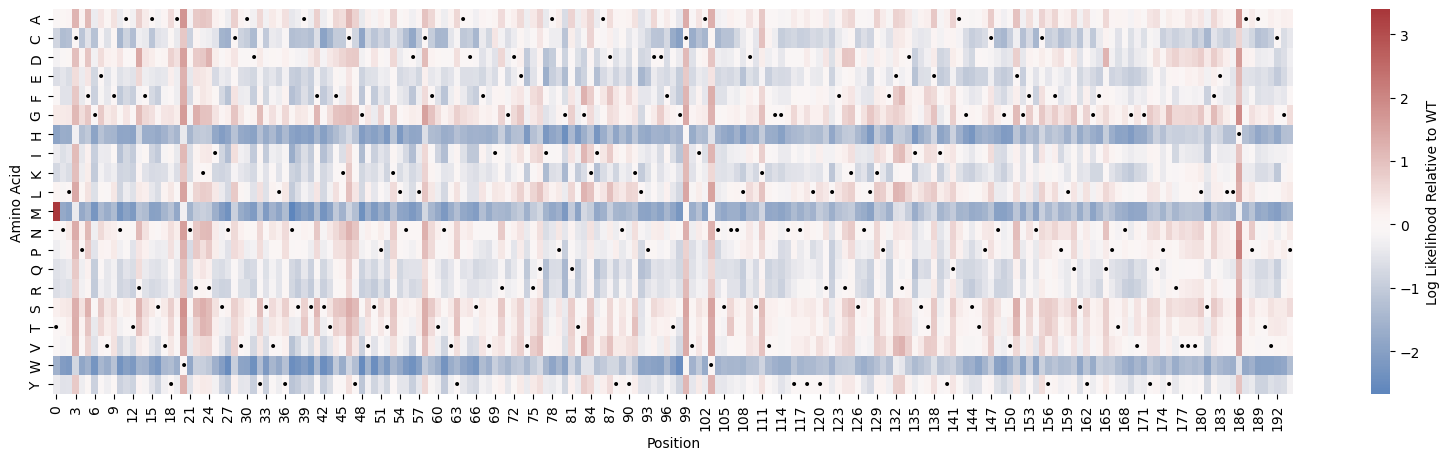

In [8]:
log_likelihoods = Seq_Utils.calculate_log_likelihoods(merged_seq, model_name="facebook/esm2_t6_8M_UR50D")
Seq_Utils.save_esm_results(log_likelihoods, "../data", merged_seq, notebook=True)
acceptable_mutations = Seq_Utils.find_acceptable_mutations(merged_seq, log_likelihoods)

Next, we will aim to better understand the energetic contributions of interface residues to binding energies between protein A and protein B/C. To do this, here I have chosen a Rosetta-based workflow, although a number of equally viable approaches are possible.

For any physics-based approach that relies on a force field to evaluate the structure, we must first ensure that the structure has been relaxed into the force field. In MD simulations, this is referred to as an equilibration protocol. In Rosetta, the most common way to achieve this is to use the FastRelax algorithm. This protocol uses repeated rounds of side chain repacking and backbone minimisations to find a local minimum. Here, I provide the `Mutate.relax_structure` to achieve this.

The below cell is needed to run an initial relaxation on the crystal structures to resolve any frustrations that may have emerged while modelling the structure into the density. This is an important step, but is by far the longest of this workflow. To this end, I have pre-relaxed the structures using the same function with the same arguments and saved the relaxed models under XXX and XXX

We will now try to get a better understanding of the energetics of the binding site. A common method to do this is use computational alanine scanning, wherein each residue is mutated to alanine and the effect of this on the binding affinity is evaluated. Here, we will use the `Mutate.scan_residue_mutants` function. This function will take an amino acid in a complex and mutate it to all other amino acids, measuring the effect on the binding energy between two proteins. As we will use the results from this later on, we will run this now and simply extract the alanine results for our alanine scanning experiment.

In theory, we could use the data generated here to run a scan for any of the 20 standard amino acids, though alanine is preferred as it is able to acommodate any secondary structure, which is not the case for other residues.

Since we aren't necessarily interested in examining the stability of protein A energetically, we will just be looking at residues of protein A that make contact with either protein B or protein C.

In [10]:
# Identify residues whose side chains make contact with prot B
prot_b_interface_residues = dict(zip(df[df["sc_bsa_protB"] > 0]["resnum"], 
                                     df[df["sc_bsa_protB"] > 0]["resname"]))

# Identify residues whose side chains make contact with prot C
prot_c_interface_residues = dict(zip(df[df["sc_bsa_protC"] > 0]["resnum"], 
                                     df[df["sc_bsa_protC"] > 0]["resname"]))


print(f"There are {len(prot_b_interface_residues.keys())} interface residues with prot B.")
print(f"There are {len(prot_c_interface_residues.keys())} interface residues with prot C.")

There are 15 interface residues with prot B.
There are 18 interface residues with prot C.


We want to make sure that a mutation that we introduce will not negatively affect binding with protein C. As such, we will scan all positions on both proteins.

In [11]:
all_interface_residues = prot_b_interface_residues | prot_c_interface_residues
print(f"There are {len(all_interface_residues.keys())} interface residues in total.")

There are 25 interface residues in total.


Next we'll run the mutational scan for each position relevant to each complex. Briefly, we'll mutate the residue of interest, repack and minimise the interface in the neighbourhood of the mutation, and then evaluate the effect on the binding energy. We only need about 1-2 minutes to evaulate all mutants for one position (using 10 cores on my local machine), as much of the heavy lifting was done with the FastRelax protocol we ran earlier.

The `Mutate.scan_residue_mutants` function takes a single position in one protein complex at a time, and in parallel calculates the effect of all possible mutations on this. It also applies a correction term to account for the additional relaxation step by mutating the residue to itself. It then saves PDB files of each mutant for future evaluation should the mutation be chosen, a bar plot of the effect of all 20 mutations for the positions, and the change in binding energy (the ddG) as an npy file.

> For each position, a separate directory is created called {chain_ID}_{resnum}.

Since the following cell also saves its output as npy files, we'll run it once and add an additional cell to load the data without having to rerun all the calculations.

In [12]:
energetics_prot_b = {}
for resnum, resname in all_interface_residues.items():
    energetics_prot_b[resnum] = np.load(f"../mutants_AB/C_{resnum}/ddgs.npy")
    
energetics_prot_c = {}
for resnum, resname in all_interface_residues.items():
    energetics_prot_c[resnum] = np.load(f"../mutants_AC/B_{resnum}/ddgs.npy")

Having calculated all the possible mutations, we'll now extract the results for mutations to alanine and add it to our DataFrame. This essentially gives us the results of our alanine scan. 

> While there is value in performing an alanine scan as an initial test to observe whether a residue being mutated does in fact affect the binding energy, it should also be noted that the main weakness of an alanine scan is that some positions will more readily accept the new alanine residue. For instance, a Val residue can easily be mutated to Ala, likely with minimal changes to the binding energy, whereas mutating a Lys to an Ala would result in much more drastic changes by virtue of their differing properties. As such, each possible mutation should be evaluated for a more complete understanding of the thermodynamics landscape of the protein complex.

In [13]:
df["ala_scan_protB"] = [energetics_prot_b[resnum][0] if resnum in energetics_prot_b.keys() else 0.0 for resnum in df["resnum"]]
df["ala_scan_protC"] = [energetics_prot_c[resnum][0] if resnum in energetics_prot_c.keys() else 0.0 for resnum in df["resnum"]]
df

,resnum,resname,within_4.5_protB,within_4.5_protC,bb_bsa_protB,sc_bsa_protB,bb_bsa_protC,sc_bsa_protC,ala_scan_protB,ala_scan_protC
0,1,T,False,False,0.0,0.0,0.0,0.0,0.0,0.0
1,2,N,False,False,0.0,0.0,0.0,0.0,0.0,0.0
2,3,L,False,False,0.0,0.0,0.0,0.0,0.0,0.0
3,4,C,False,False,0.0,0.0,0.0,0.0,0.0,0.0
4,5,P,False,False,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
190,191,T,False,False,0.0,0.0,0.0,0.0,0.0,0.0
191,192,V,False,False,0.0,0.0,0.0,0.0,0.0,0.0
192,193,C,False,False,0.0,0.0,0.0,0.0,0.0,0.0
193,194,G,False,False,0.0,0.0,0.0,0.0,0.0,0.0


We'll now visualise the results of the alanine scan. Indeed, our results here confirm our hypothesis based on BSA measurements. There are positions in protein A whose mutation to Ala has a marked effect on binding to protein B without affecting protein C. A cluster of candidate residues is found roughly between psoitions 144-155.

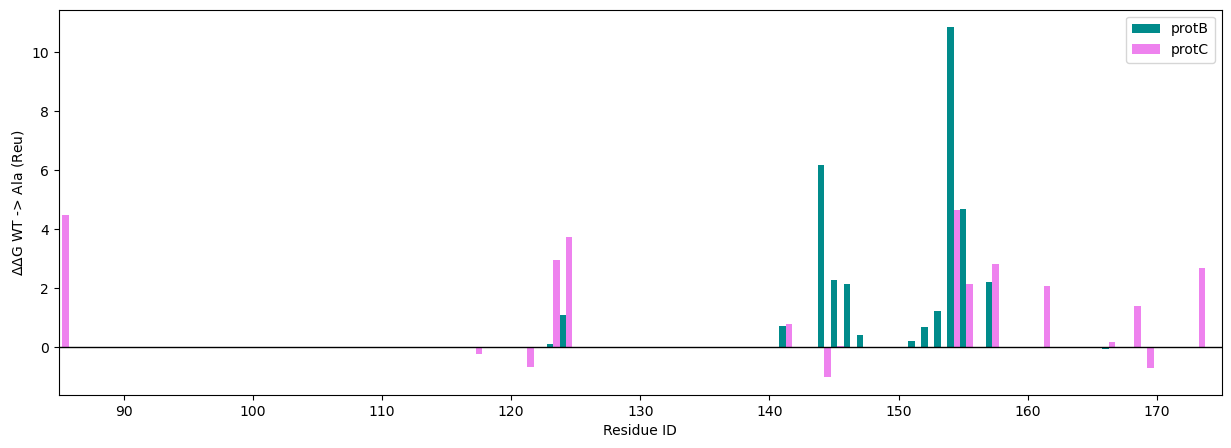

In [14]:
f = plt.figure(figsize=[15,5])
plt.bar(df["resnum"], df["ala_scan_protB"], 0.5, label="protB", color="darkcyan")
plt.bar(df["resnum"]+0.5, df["ala_scan_protC"], 0.5, label="protC", color="violet")
plt.xlim(85,175)
plt.xlabel("Residue ID")
plt.ylabel("$\Delta\Delta$G WT -> Ala (Reu)")
plt.legend(loc="best")
plt.axhline(y=0, c="black", linewidth=1)
plt.show()

We should also visualise this on our protein structure itself. To do this, we'll replace the B-factor column of protein A with either 0 (for untested positions) or the change in binding energy upon mutation to alanine in Rosetta energy units (Reu).

In [15]:
import importlib
importlib.reload(Utils)

prot_B_ala_scan_bfacs = dict(zip(df["resnum"], df["ala_scan_protB"]))
prot_C_ala_scan_bfacs = dict(zip(df["resnum"], df["ala_scan_protC"]))


Utils.replace_bfactors("../data/complex_AB_fixed_prot_A.pdb", 
                       "../data/complex_AB_fixed_prot_A_ala_scan.pdb", 
                       prot_B_ala_scan_bfacs)
Utils.replace_bfactors("../data/complex_AC_fixed_prot_A.pdb", 
                       "../data/complex_AC_fixed_prot_A_ala_scan.pdb", 
                       prot_C_ala_scan_bfacs)

When we visualise this using PyMol, we do indeed see that protein B (right) tends to interact more with the protruding coil on protein A, although one position that is targeted by both proteins seems to have the greatest energetic contribution.

![image](../figures/ala_scan_comp.png)


We now get the positions where only affinity to protein B was affected:

In [16]:
positions_to_evaluate = df[(df["ala_scan_protB"] > 0.0) & (df["ala_scan_protC"] < 1)]
positions_to_evaluate

,resnum,resname,within_4.5_protB,within_4.5_protC,bb_bsa_protB,sc_bsa_protB,bb_bsa_protC,sc_bsa_protC,ala_scan_protB,ala_scan_protC
112,113,V,False,False,0.000000,0.000000,0.000000,4.830513,0.000043,-0.001847
140,141,Y,False,True,0.000000,1.698973,0.000000,7.109600,0.711656,0.798374
143,144,G,True,True,0.000000,10.193840,7.245769,0.000000,6.164234,-1.020970
144,145,S,True,False,8.494867,12.780703,1.093588,0.000000,2.274902,0.049295
145,146,T,True,False,0.000000,54.547649,0.000000,0.000000,2.150728,0.000079
146,147,P,False,False,9.643131,18.555503,0.000000,0.000000,0.427339,0.000006
148,149,N,True,False,0.000000,27.798697,0.000000,0.000000,0.001110,-0.000005
150,151,V,True,False,0.000000,14.308070,0.000000,0.000000,0.204711,0.000021
151,152,E,True,True,21.565350,58.741198,0.000000,15.000426,0.691046,-0.000175
152,153,G,True,False,18.917779,28.882546,0.000000,0.000000,1.239900,0.000209


Finally, we'll enumerate the possible mutations and rank them. First, we'll go through all of the mutations we introduced to the protein B complex and see if they are beyond some threshold in terms of destabilisation. Arbitrarily, we'll set this to > +1 Reu. Then, we'll see if the mutation in that position is within the allowed mutants given by our ESM-based scoring. Lastly, we'll ensure that the mutation has not resulted in an increase in the binding energy change for protein C.

In [17]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
mut_resnum, wt_res, mut_res, protB_effect, protC_effect = [], [], [], [], []

for resnum, resname in prot_b_interface_residues.items():
    for i, amino_acid in enumerate(amino_acids):
        if (amino_acid in acceptable_mutations[resnum] and
            energetics_prot_b[resnum][i] > 1 and
            energetics_prot_c[resnum][i] <= 0.5):
            mut_resnum.append(resnum)
            wt_res.append(resname)
            mut_res.append(amino_acid)
            protB_effect.append(energetics_prot_b[resnum][i])
            protC_effect.append(energetics_prot_c[resnum][i])

df_mutations = pd.DataFrame({
    "resid": mut_resnum,
    "wt": wt_res,
    "mut": mut_res,
    "protB_ddg": protB_effect,
    "protC_ddg": protC_effect
}).sort_values('protB_ddg', ascending=False)

print(f"{len(df_mutations)} possible mutations have been identified.")

df_mutations[:10]

41 possible mutations have been identified.


,resid,wt,mut,protB_ddg,protC_ddg
21,149,N,P,9.705504,-0.067794
6,144,G,T,9.281918,-0.487325
4,144,G,P,9.043193,-0.261613
5,144,G,S,7.426758,0.235538
3,144,G,F,7.247008,-0.871776
2,144,G,A,6.164234,-1.020970
38,153,G,Y,5.980365,0.003067
36,153,G,T,5.751637,0.000346
15,146,T,D,4.184174,0.000107
34,153,G,P,4.126017,-1.032892


Of these 41 mutations, we could now start by experimentally validating the most promising ones. Alternatively, we may choose to carry these mutations into further analysis using more resource-intensive methods like binding free energy calculations using molecular dynamics simulations for further confirmation. Further, repeating the mutational scan using Rosetta may allow for further confirmation of the results presented here.

As a case study, we will have a brief look at position 144, which is a Gly in the WT structure and seems to be imperative for the protein AB complex. Indeed, our the plot saved under `../mutants_AB/C_144/ddg_plot.pdf` shows that all residues other than the WT destabilise the structure significantly, whereas in the case of complex AC there are mutations that do not have a negative impact on the structure (`../mutants_AC/C_144/ddg_plot.pdf`). Examining the PDB files generated for the WT -> WT mutation as well as the most destabilising G144T (per energy) and another bulky mutation (G144F) we see that the Gly residue is able to acommodate an Asp residue from the CDR-H3 loop of the antibody (shown in yellow), which then makes two polar contacts with protein A. Upon mutation, this residue is forced to rotate inwards into a hydrohphobic pocket, which leads to a loss of the polar contacts and destabilisation of the complex:

![image](../figures/G144_analysis.png)
